In [1]:
# --- Imports ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm
ranfom_seed = 42
# If you use tableone for balance diagnostics:
# pip install tableone
from tableone import TableOne

### Load and Process Original dataset - 2018

In [2]:
data = pd.read_csv("loaded_student_data_2018.csv")

In [3]:
data = data.drop(columns=['dishwasher','stu_wgt', 'car', 'computer_n', 'television','science', 'read', 'math','year','school_id','student_id','wealth'])

#### computing propensity score and trimming the data with scores out the range [0.05-0.95]

In [4]:
# Define treatment and outcome
T = data['computer']  # Binary treatment: 1 = has computer, 0 = no
y = data['achievement']       # Outcome: average score of math, read, and science

# Define confounders (exclude country, T, and Y)
excluded_cols = ['achievement', 'computer','internet']  # internet is a mediator
confounders = [col for col in data.columns if col not in excluded_cols]
X = data[confounders]

In [5]:
# Train-validation split
X_train, X_val, T_train, T_val, y_train, y_val = train_test_split(X, T, y, test_size=0.3, random_state=42)


## Estimation

### Matching2

In [9]:
def precompute_matching(X, T, match_cols=None, nn_algo='ball_tree'):
    """
    Precompute 1-NN control for each treated unit.
    Returns:
        - matching_dict: {treated_index -> control_index}
        - treated_idx: list of treated indices
        - control_idx: list of control indices
    """
    if match_cols is None:
        match_cols = X.columns

    # Subset matrices
    X_treated = X.loc[T == 1, match_cols]
    X_control = X.loc[T == 0, match_cols]

    treated_idx = X_treated.index.tolist()
    control_idx = X_control.index.tolist()

    # NN on controls
    nn = NearestNeighbors(n_neighbors=1, algorithm=nn_algo)
    nn.fit(X_control)
    distances, indices = nn.kneighbors(X_treated)

    matching_dict = {}
    for i, idx in enumerate(indices):
        treated_i = treated_idx[i]
        control_i = control_idx[idx[0]]
        matching_dict[treated_i] = control_i

    return matching_dict, treated_idx, control_idx

In [10]:
def collect_pairs_from_sample(sampled_treated_idx, matching_dict, enforce_unique_control=False):
    pairs = []
    for ti in sampled_treated_idx:
        ci = matching_dict.get(ti, None)
        if ci is None:
            continue
        pairs.append((ti, ci))
    return pairs


In [11]:
def outcomes_from_pairs(y, pairs):
    """
    Given a list of (treated_idx, control_idx) pairs, return aligned outcome arrays.
    """
    if not pairs:
        return np.array([]), np.array([])
    y_t = np.array([y.loc[ti] for ti, _ in pairs])
    y_c = np.array([y.loc[ci] for _, ci in pairs])
    return y_t, y_c


In [12]:
def att_from_pairs(y_treated, y_control):
    """
    Pairwise ATT: mean(y_treated - y_control).
    """
    if len(y_treated) == 0 or len(y_treated) != len(y_control):
        raise ValueError("Empty pairs or unequal treated/control pair counts.")
    return float(np.mean(y_treated - y_control))


In [13]:
# --- Precompute matches on the validation split ---
matching_dict_val, treated_idx_val, control_idx_val = precompute_matching(X_val, T_val)

In [14]:
# Build full matched pairs once (use each treated once; enforce 1:1 control reuse within this set)
full_pairs_val = collect_pairs_from_sample(treated_idx_val, matching_dict_val, enforce_unique_control=True)
y_t_full, y_c_full = outcomes_from_pairs(y_val, full_pairs_val)


In [15]:
# ATT on full matched validation set (pairwise safe)
att_val = att_from_pairs(y_t_full, y_c_full)
print(f"Estimated ATT (Matching, Full Data): {att_val:.4f}")

Estimated ATT (Matching, Full Data): 23.0379


In [16]:
def matching_confidence_intervals_fast(
    X, T, y, matching_dict,
    n_bootstrap=1000, alpha=0.05, random_seed=42, enforce_unique_control=True
):
    rng = np.random.default_rng(random_seed)
    treated_indices = [i for i in T.index if T.loc[i] == 1]

    att_estimates = []
    for _ in tqdm(range(n_bootstrap), desc="Bootstrapping Matching ATT"):
        sampled_treated_idx = rng.choice(treated_indices, size=len(treated_indices), replace=True)
        pairs = collect_pairs_from_sample(sampled_treated_idx, matching_dict, enforce_unique_control)
        y_t, y_c = outcomes_from_pairs(y, pairs)
        if len(y_t) == 0:
            # No valid pairs in this draw; skip
            continue
        att_estimates.append(att_from_pairs(y_t, y_c))

    if len(att_estimates) == 0:
        raise RuntimeError("No valid bootstrap draws produced an ATT estimate.")

    lower = np.percentile(att_estimates, 100 * alpha / 2)
    upper = np.percentile(att_estimates, 100 * (1 - alpha / 2))
    return lower, upper, att_estimates

In [17]:
lower, upper, att_dist = matching_confidence_intervals_fast(
    X_val, T_val, y_val, matching_dict_val, n_bootstrap=1000, alpha=0.05, random_seed=42
)

Bootstrapping Matching ATT: 100%|██████████| 1000/1000 [41:28<00:00,  2.49s/it]


In [18]:
print(f"Matching ATT 95% CI: [{lower:.4f}, {upper:.4f}]")

Matching ATT 95% CI: [22.4922, 23.5640]


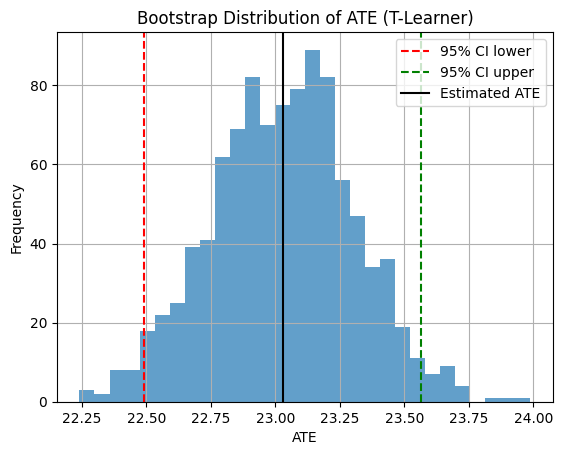

In [20]:
alpha=0.05

plt.hist(att_dist, bins=30, alpha=0.7)
plt.axvline(lower, color='red', linestyle='--', label=f'{(1-alpha)*100:.0f}% CI lower')
plt.axvline(upper, color='green', linestyle='--', label=f'{(1-alpha)*100:.0f}% CI upper')
plt.axvline(np.mean(att_dist), color='black', linestyle='-', label='Estimated ATE')
plt.legend()
plt.title('Bootstrap Distribution of ATE (T-Learner)')
plt.xlabel('ATE')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()